# TP de Méthodes Numériques :
# Algorithme de réaction-diffusion pour la détection de la neige par satellite

### Equipe :

#### Belharir Khalil, G1

#### Aboutni Hamza, G1


#### Résumé :
Dans ce TP, on simule une équation de réaction-diffusion à l'aide d'un schéma aux différences finies.
L'équation est de type bistable, i.e. possède deux états d'équilibres stables spatialement homogènes.
La dynamique est appliquée à des images satellites radar (SAR) afin d'y délimiter des zones de neige
(problématique de segmentation d'image), et les résultats sont comparés à des mesures optiques satellitaires.
<br>
<br>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Les lectures des données utilisées dans le TP
(mesures SAR, optiques, données d'altitude) 
s'effectuent avec l'instruction :
<br>
**u = np.loadtxt("fname",delimiter=',')**
<br>
où **fname** est le nom d'un fichier texte contenant des données et
**u** un tableau.
<br>
<br>

### Partie 1 : codage et test de l'algorithme de réaction-diffusion

#### Question 1 
Ecrire une fonction **laplacien** qui prend en argument une matrice 
$(u_{i,j})$ (tableau 2D) de dimension $(m,n)$ arbitraire et calcule son laplacien discret
avec conditions aux limites de Neumann homogènes :
$$
{(\Delta_d{u})}_{i,j} =
u_{i+1,j}   +u_{i-1,j} + u_{i,j+1} +u_{i,j-1} -4\, u_{i,j},
\quad
0\leq i \leq m-1 , 0\leq j \leq n-1 ,
$$
où on note
$u_{-1,j}=u_{0,j}$, 
$u_{m,j} = u_{m-1,j}$, 
$u_{i,-1} = u_{i,0}$,
$u_{i,n} = u_{i,n-1}$.

Suggestion : on pourra utiliser la fonction **numpy.pad**
pour prendre en compte ces conditions aux limites.

#### Réponse :

In [4]:
def laplacien(u):
    #On utilise numpy.pad pour pour prendre en compte les conditions aux limites.
    padded_u = np.pad(u, ((1, 1), (1, 1)), mode='edge')
    #Relation de récurrence
    laplacian = (padded_u[1:-1, :-2] + padded_u[1:-1, 2:] +
                 padded_u[:-2, 1:-1] + padded_u[2:, 1:-1] - 4 * padded_u[1:-1, 1:-1])
    return laplacian

In [5]:
u=[[1,0,0],[0,1,0],[0,0,1]]
print(laplacien(u))

[[-2  2  0]
 [ 2 -4  2]
 [ 0  2 -2]]


#### Question 2
On considère une équation de diffusion avec conditions aux limites de Neumann homogènes,
discrétisée par le schéma d'Euler explicite :
<br>
pour $0\leq i \leq m-1$, $0\leq j \leq n-1$, $k \geq 0$ :
$$
u_{i,j}^{(k+1)}
=
\mu\, \big( u_{i+1,j}^{(k)}   +u_{i-1,j}^{(k)} + u_{i,j+1}^{(k)} +u_{i,j-1}^{(k)} -4\, u_{i,j}^{(k)} \big) 
+u_{i,j}^{(k)},
$$
avec conditions aux limites
$u_{-1,j}^{(k)}=u_{0,j}^{(k)}$,
$u_{m,j}^{(k)}=u_{m-1,j}^{(k)}$,
$u_{i,-1}^{(k)} = u_{i,0}^{(k)}$,
$u_{i,n}^{(k)}=u_{i,n-1}^{(k)}$.
<br>
On a $\mu = \frac{D\, \Delta{t}}{h^2}$, où $D>0$ est le coefficient de diffusion,
$\Delta t >0$ le pas de temps et $h$ le pas d'espace.

#### 2-a )
Montrer que la moyenne des composantes
$$
\bar{u}^{(k)}= \frac{1}{m\, n}\sum_{0\leq i \leq m-1 , 0\leq j \leq n-1}{u_{i,j}^{(k)}}
$$
est indépendante de $k$.

En utilisant le schéma d’Euler :
$$
u^{(k)}_{i, j} = \mu \cdot \left( u^{(k-1)}_{i+1, j} + u^{(k-1)}_{i-1, j} + u^{(k-1)}_{i, j+1} + u^{(k-1)}_{i, j-1} - 4 \cdot u^{(k-1)}_{i, j}\right) +u^{(k-1)}_{i, j}
$$
Pour $k>0$ :
On développe chacun des 4 termes $$u^{(k-1)}_{i+1, j} , u^{(k-1)}_{i-1, j} , u^{(k-1)}_{i, j+1} ,u^{(k-1)}_{i, j-1} $$
Comme ceci : 
$$\sum_{0\leq i \leq m-1 , 0\leq j \leq n-1} u^{(k)}_{i+1, j}=mn\cdot\left(\bar{u}^{(k-1)} - \sum_{0\leq j \leq n-1}{u_{0,j}^{(k-1)}} + \sum_{0\leq j \leq n-1}{u_{n,j}^{(k-1)}}\right)$$

Et en utilisant les conditions aux limites $(9)$, on obtient :
$$\bar{u}^{(k)}=\bar{u}^{(k-1)}$$
Ceci étant vrai pour $u^{(k-1)}_{i+1, j} , u^{(k-1)}_{i-1, j} , u^{(k-1)}_{i, j+1} ,u^{(k-1)}_{i, j-1} $ de la même manière, on a :
 $$\bar{u}^{(k)}=\bar{u}^{(0)}$$


#### 2-b )
Ecrire une fonction **diffusion** qui
prend en arguments la condition initiale $(u_{i,j}^{(0)})_{0\leq i \leq m-1 , 0\leq j \leq n-1}$,
le nombre d'itérations $k_{\mathrm{max}}$ et le coefficient $\mu$,
et qui calcule $(u_{i,j}^{(k_{\mathrm{max}})})_{0\leq i \leq m-1 , 0\leq j \leq n-1}$
avec le schéma d'Euler explicite.

In [129]:
def diffusion(u0,kmax,mu):
    m, n = u0.shape
    u = u0.copy()
    
    for k in range(kmax):
        u_new = u + mu*laplacien(u)
        u = u_new
    
    return u

#### 2-c )
On fixe $\mu = 0.2$ et on considère la condition initiale $(u_{i,j}^{(0)})$ correspondant 
aux données d'intensité SAR du fichier "sar.dat"
(avec $m=540$ et $n=532$).
Afficher les images en niveaux de gris correspondant à
$(u_{i,j}^{(k)})$ pour $k=0,10,100,1000$
itérations et commenter. 
Vérifier numériquement la conservation de
la moyenne des composantes
afin de tester la cohérence des calculs.
<br><br>
Pour afficher les images correspondant à 
$(u_{i,j}^{(k)})_{0\leq i \leq m-1 , 0\leq j \leq n-1}$, on pourra utiliser les fonctions
**imshow** ou **pcolormesh**
avec le paramètre **cmap=plt.get_cmap('gray')**,
ainsi que **colorbar** pour indiquer les valeurs.

Lecture de la condition initiale $(u_{i,j}^{(0)})$ :

In [130]:
u0 = np.loadtxt("sar.dat",delimiter=',')

#### Réponse :


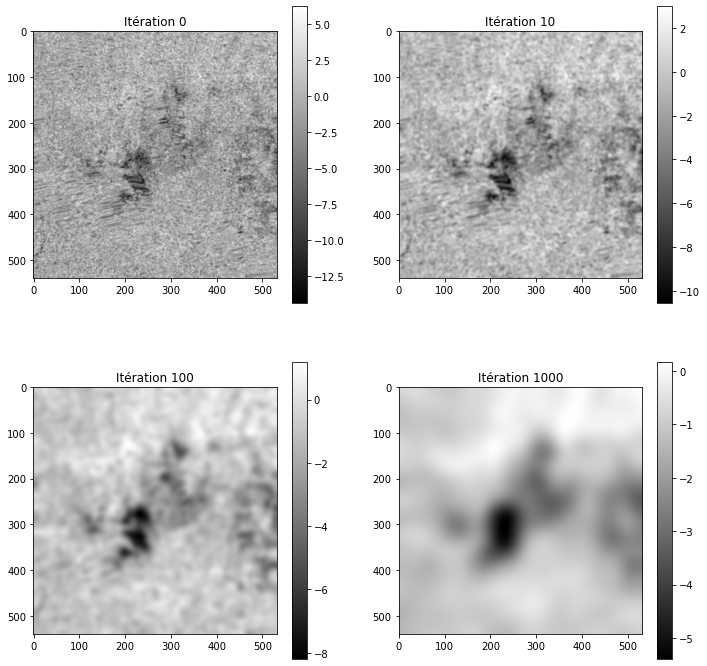

In [132]:
m, n = u0.shape
kmax = [0, 10, 100, 1000]
mu=0.2
plt.figure(figsize=(12,12))
for i, k in enumerate(kmax):
    u = diffusion(u0, k, mu)
    plt.subplot(2, 2, i+1)
    plt.imshow(u, cmap='gray')
    plt.colorbar()
    plt.title(f'Itération {k}')


On observe que la solution s'affine au cours du temps ie avec une augmentation du nombre d'opérations (voir une convergence de notre système). Si bien que les contours de chaque points deviennent flous.

In [135]:
mean0=np.mean(u0)
meank=np.mean(u)
print(mean0, meank)
print("On observe bien que les valeurs sont similaires (ie ne dépend pas de k) donc notre solution est bonne.")

-1.2396449541905254 -1.2396449541905252
On observe bien que les valeurs sont similaires (ie ne dépend pas de k) donc notre solution est bonne.


#### Question 3
On considère maintenant la non-linéarité bistable
$$
f(u) = 
\left\{
\begin{array}{rl}
-u-4 & \mbox{si}\ u<-2,\\
-u & \mbox{si}\ u\geq -2,
\end{array}
\right.
$$
et le schéma d'Euler explicite pour l'équation de réaction-diffusion associée à $f$ :
<br>
pour $0\leq i \leq m-1$, $0\leq j \leq n-1$, $k \geq 0$ :
$$
u_{i,j}^{(k+1)}
=
\mu\, \big( u_{i+1,j}^{(k)}   +u_{i-1,j}^{(k)} + u_{i,j+1}^{(k)} +u_{i,j-1}^{(k)} -4\, u_{i,j}^{(k)} \big) 
+u_{i,j}^{(k)}
+ \Delta{t}\, f(u_{i,j}^{(k)}),
$$
avec conditions aux limites de Neumann homogènes
$u_{-1,j}^{(k)}=u_{0,j}^{(k)}$,
$u_{m,j}^{(k)}=u_{m-1,j}^{(k)}$,
$u_{i,-1}^{(k)} = u_{i,0}^{(k)}$,
$u_{i,n}^{(k)}=u_{i,n-1}^{(k)}$.

#### 3-a)
<br>
On suppose que la condition suivante est vérifiée :
$$
\mu < \frac{1-\Delta{t}}{4}
$$
(cette condition implique $\Delta{t}<1$ puisque $\mu >0$).
Démontrer les implications :
$$
\big( \,  -2 \leq u_{i,j}^{(0)}  \quad  \forall\, (i,j) \, \big)
\Rightarrow
\big( \,
\lim_{k\rightarrow +\infty}{ u_{i,j}^{(k)}  }=0  \quad  \forall\, (i,j)
\, \big)
,
$$
$$
\big( \, u_{i,j}^{(0)} <-2 \quad  \forall\, (i,j) \, \big)
\Rightarrow
\big( \,
\lim_{k\rightarrow +\infty}{ u_{i,j}^{(k)}  }=-4  \quad  \forall\, (i,j)
\, \big).
$$

#### Réponse :
<br>
Il existe $p \in \left] 0, 1- \Delta{t} \right[$ tel que $\mu =\frac{p}{4}$.
Posons $m = \left( u_{i+1,j}^{(k)}   + u_{i-1,j}^{(k)} + u_{i,j+1}^{(k)} +u_{i,j-1}^{(k)} \right)$
Si $u_{i,j}^{(0)}\geq -2$ montrons par récurrence que l'on a $u_{i,j}^{(k)}\geq -2$ pour tout $k\geq 0$, on a d'après (8): 
$$u_{i,j}^{(k+1)} = \mu\, \left( u_{i+1,j}^{(k)} +u_{i-1,j}^{(k)} + u_{i,j+1}^{(k)} +u_{i,j-1}^{(k)} -4\, u_{i,j}^{(k)} \right) + u_{i,j}^{(k)} + \Delta{t}\, f(u_{i,j}^{(k)})$$ 
$$=\frac{p}{4} m + -4 u_{i,j}^{(k)} +u_{i,j}^{(k)} - \Delta{t} u_{i,j}^{(k)}$$ par hypothèse de récurrence
$$=\frac{p}{4} m - p u_{i,j}^{(k)} + (1 - \Delta{t}) u_{i,j}^{(k)}$$ 
$$\geq (-2)p + 2p + (1 - \Delta{t})(-2)$$ par hypothèse de récurrence et par définition $m \geq -8$
$$\geq -2$$ car $1 - \Delta{t} \leq 1$ 


Ainsi, on a : |f(x)-f(y)| $\leq$ |x - y| pour tout i, j, $\Delta{t}$ car $u_{i,j}^{(k)} + 2 $ converve son signe si $u_{i,j}^{(0)}\geq -2$. donc f est lipschitzienne continue, ie que le shéma converge d'après le cours vers une unique solution l lorsque $u_{i,j}^{(0)}\geq -2$. On a alors par passage à la limite dans (8) : 
$$ l = (1 - \Delta{t}) l$$
ie $$l = 0$$ car $0 < 1 - \Delta{t} < 1$
d'où l = 0.
$lim_{k\rightarrow +\infty}{ u_{i,j}^{(k)}}$
On a alors pour le deuxième résultat : 
$$u_{i,j}^{(0)} <-2 \quad  \forall\, (i,j) $$
ie $$-u_{i,j}^{(0)} > 2 \quad  \forall\, (i,j)$$
ie $$-u_{i,j}^{(0)} - 4 > -2 \quad  \forall\, (i,j)$$
Et on a donc de la même manière le même résultat pour la suite $(-u_{i,j}^{(k)} - 4)_k$ ie :
$lim_{k\rightarrow +\infty}{ -u_{i,j}^{(k)} - 4} = 0$ ie $lim_{k\rightarrow +\infty}{ u_{i,j}^{(k)} } = 4$


#### 3-b)
Illustrer numériquement les deux implications énoncées dans la question **3-a)**
pour des valeurs de votre choix de $\mu$, $\Delta{t}$, $(m,n)$
et des conditions initiales $u_{i,j}^{(0)}$ tirées au hasard
au dessus ou au dessous de la valeur seuil $-2$
(utiliser la fonction **numpy.random.rand**).

#### Réponse :
<br>

Doit converger vers 0
[[-1.03220212  4.14581832  3.40369127  2.04110301 -0.54622093  7.3279818
   3.82417074  9.39028347 -0.33740707  5.8462638 ]
 [ 6.78556247 -1.64826493  3.30369878  2.7165219   7.47112767 10.61404587
   0.55544617  8.04880157 -1.01048206  9.40066162]
 [ 7.09397786  8.22055765  8.41384441  5.26384558 10.45414361  6.70522433
   3.82850795 -1.44550226  5.10019655  0.53650554]
 [ 0.93191049  6.57244096 -1.98737596  9.78417077  2.03395162 10.96852704
   5.59022874  3.27645162 -0.94449517  9.28495375]
 [ 8.76842603  4.9925378   4.24308992 -1.96781092 10.83310103  4.86922926
  -1.00129159  5.60723169 -0.07532118 10.34287273]
 [ 2.02356061  3.85333848 -0.52316816  1.87833976 -0.48911397  0.40051932
  -1.98939802  9.94892226  9.51625573  2.52573027]
 [ 4.49244741  8.5742329   1.79209368  3.91749402 -0.05494431  4.12012862
   6.07796153  1.33545852 10.56371679  1.67490132]
 [10.4678148   4.86322888 -1.49684672  5.67811928  9.33323413 10.77572759
   7.34828839  3.47926427  0.8

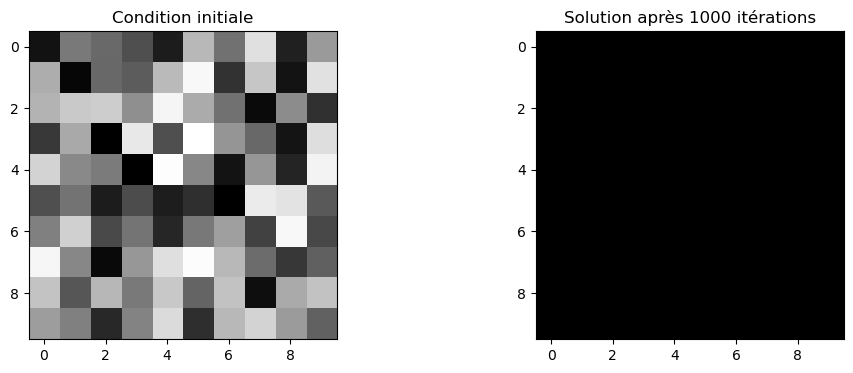

In [5]:
def f(u):
    return np.where(u<-2,-u-4,-u)


# Paramètres
m, n = 10, 10
kmax = 1000
mu = 0.2
dt = 0.25
valeur_init=np.random.randint(low=0,high=2)
print(f"Doit converger vers {-4 * valeur_init}")
if valeur_init  :  # Condition initiale <-2
    u0 = np.random.uniform(-12,-2,size=(m,n))
else : # Condition initiale >= -2
    u0 = np.random.uniform(-1.9999,11,size=(m,n))


print(u0)

# Évolution de la solution
u = u0.copy()
for k in range(kmax):
    u_new = u + mu*laplacien(u) + dt*f(u)
    u = u_new
u = np.round(u, 25)
print(u)

# Affichage des résultats
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(u0, cmap='gray')
plt.title('Condition initiale')
plt.subplot(1,2,2)
plt.imshow(u, cmap='gray')
plt.title(f'Solution après {kmax} itérations')
plt.show()

#### 3-c)
Reprendre les valeurs de $\mu$, $\Delta{t}$, $(m,n)$ de la question **3-b**
avec cette fois des conditions initiales
$u_{i,j}^{(0)}$ tirées au hasard dans $[-10,6[$.
Qu'observez-vous ?

#### Réponse :
<br>

[[ 1.39248644  1.97589764  2.24541034 -4.42183779 -2.38653261 -1.04452313
   2.59236555 -9.86376882 -1.25544071 -6.17950443]
 [-7.68172424 -6.39633564  3.67987484  3.70218489  0.38108005 -9.67649649
   2.70289177 -2.95533594 -8.97806766  1.35989257]
 [ 4.69696526 -2.84709254 -6.29783989 -5.15820103 -6.74733765 -3.64887156
   4.9805278  -0.88499655 -2.14557301 -1.78842185]
 [-7.62819459 -2.76182888  0.17938465 -6.48499269 -7.35224629  3.00769097
  -5.65371172 -1.24501322 -4.31596143  5.99222291]
 [-3.69687938 -8.77294846 -9.70733353  3.34002066 -2.3572095  -6.29319245
   0.7214463   3.5010488   2.0075999  -6.54378352]
 [ 4.61134177 -2.71840035 -0.91836031 -4.12853716 -2.52570532 -1.0597224
   1.55240057 -0.72492804  2.95452807  2.05962211]
 [ 3.11463115 -4.4022758  -2.64366603  3.60660833  4.71186853 -6.18701356
  -4.4182309  -0.94188665 -9.14056056 -1.07386889]
 [ 5.33567671  0.57407049 -9.43950922 -5.24505043 -1.37741068 -3.6545681
   2.91395116  0.64981733  1.00744905 -3.93663238]
 [

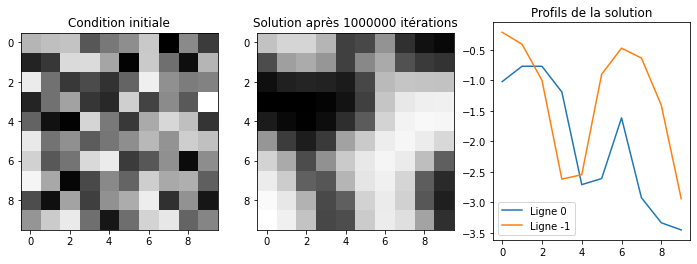

In [136]:
def f(u):
    return np.where(u<-2,-u-4,-u)

# Paramètres
m, n = 10, 10
kmax = 1000000
mu = 0.2
dt = 0.25

# Condition initiale aléatoire
u0 = np.random.uniform(-10, 6, (m, n))

print(u0)
# Évolution de la solution
u = u0.copy()
for k in range(kmax):
    u_new = u + mu*laplacien(u) + dt*f(u)
    u = u_new

print(u)
# Affichage des résultats
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(u0, cmap='gray')
plt.title('Condition initiale')
plt.subplot(1,3,2)
plt.imshow(u, cmap='gray')
plt.title(f'Solution après {kmax} itérations')
plt.subplot(1,3,3)
plt.plot(u[0,:], label='Ligne 0')
plt.plot(u[-1,:], label='Ligne -1')
plt.legend()
plt.title('Profils de la solution')
plt.show()

On observe qu'une partie des éléments convergent vers -4 et les autres vers 0. Cela provient de la valeur initiale des $u_{i,j}^{(0)}$


#### 3-d)
On fixe $\Delta{t}=1$ (la condition $\mu < (1-\Delta{t})/4$ n'est donc pas vérifiée).
Représenter $\| (u_{i,j}^{(k)})  \|_{\infty}= \mathrm{max}_{i,j}|u_{i,j}^{(k)}|$
en fonction de $k$
pour des conditions initiales $u_{i,j}^{(0)}$ tirées au hasard dans $[-2,2[$
et différentes valeurs de $\mu$. Commenter les résultats.

#### Réponse :
<br>

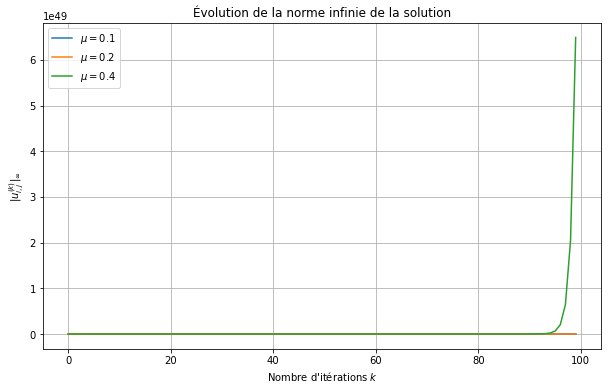

In [54]:
def f(u):
    return np.where(u<-2,-u-4,-u)


# Paramètres
m, n = 540, 532
kmax = 100
dt = 1  # Condition (12) non vérifiée

# Différentes valeurs de mu
mu_values = [0.1, 0.2, 0.4]

# Tracé des courbes
plt.figure(figsize=(10,6))
for mu in mu_values:
    # Condition initiale aléatoire dans [-2, 2[
    u0 = np.random.uniform(-2, 2, (m, n))
    
    # Évolution de la solution
    u = u0.copy()
    norm_inf = []
    for k in range(kmax):
        u_new = u + mu*laplacien(u) + dt*f(u)
        u = u_new
        norm_inf.append(np.max(np.abs(u)))
    
    plt.plot(norm_inf, label=f'$\mu = {mu}$')

plt.xlabel('Nombre d\'itérations $k$')
plt.ylabel('$\|u^{(k)}_{i,j}\|_\infty$')
plt.title('Évolution de la norme infinie de la solution')
plt.legend()
plt.grid()
plt.show()

#### 3-e)
Faire une synthèse des résultats précédents, en indiquant les points communs
ou les différences (suivant les valeurs de $\mu$, $\Delta{t}$)
entre les propriétés 
du schéma d'Euler explicite et celles des équations différentielles 
de type réaction-diffusion bistables 
quand $t\rightarrow +\infty$.

#### Réponse :
<br> 
Les propriétés du schéma d'Euler explicite reflètent étroitement celles des équations différentielles réaction-diffusion bistables. En effet, nous avons déterminé l'existence d'un seuil critique à c=-2, qui divise l'espace des valeurs initiales : au-dessus de ce seuil, la solution converge vers 0, tandis qu'en-dessous, elle converge vers -4. Ces conclusions concordent avec les caractéristiques classiques des équations différentielles de type réaction-diffusion bistables, qui présentent généralement deux états d'équilibre stables séparés par un seuil. De plus, d'après nos observations basées sur les résultats de l'algorithme, chaque condition initiale correspond à une limite finale unique lorsque le temps tend vers l'infini. Deux limites distinctes émergent ainsi : 0 et -4. Ce schéma de comportement bimodal est particulièrement marqué lorsque les valeurs initiales sont choisies dans l'intervalle [-10, 6[, où la solution converge soit vers 0, soit vers -4 selon la position par rapport au seuil critique.

### Partie 2 : segmentation d'images SAR et comparaison à l'optique

Dans la suite du TP on fixe
$$
\mu = \frac{1-\Delta{t}}{5}
$$
dans le schéma d'Euler explicite décrit dans la **question 3**.

#### Question 4
Ecrire une fonction **segmente** qui
prend en arguments la condition initiale $(u_{i,j}^{(0)})_{0\leq i \leq m-1 , 0\leq j \leq n-1}$,
le pas de temps $\Delta{t}$, un nombre maximal d'itérations $k_{\mathrm{max}}$, une tolérance $\eta$,
et qui renvoie $(u_{i,j}^{(k)})$, 
la matrice $(S(u_{i,j}^{(k)}))$ correspondant à l'image binarisée :
$$
S(u) = 
\left\{
\begin{array}{rl}
1 & \mbox{si}\ u<-2,\\
0 & \mbox{si}\ u\geq -2,
\end{array}
\right.
$$
et le nombre d'itérations $k$ réalisé, tels que :
$$
k = \mathrm{min}(k_{\mathrm{cv}},k_{\mathrm{max}}), \quad
k_{\mathrm{cv}} = \inf\{ \, \mathrm{k}\geq 1,\, \| (S(u_{i,j}^{(\mathrm{k})}))-(S(u_{i,j}^{(\mathrm{k}-1)}))  \|_1  \leq \eta \, \},
$$
où $\| \,  \|_1$ correspond à la moyenne des modules des composantes :
$$
\| A  \|_1 = \frac{1}{m\, n}\sum_{0\leq i \leq m-1 , 0\leq j \leq n-1}{|a_{i,j}|}.
$$

In [55]:
def f(u):
    return np.where(u<-2,-u-4,-u)
def norme1(A):
    return np.sum(np.abs(A))/(n*m)
def segmente(u0, dt, kmax, eta):

    m, n = u0.shape
    u = u0.copy()
    # Calcul du coefficient de diffusion
    mu = (1 - dt) / 5
    cv =False
    
    # Itération jusqu'à convergence ou nombre maximal d'itérations atteint
    for k in range (1,kmax+1) :
        u_new = u + mu*laplacien(u) + dt*f(u)
        u = u_new
        S = np.where(u < -2, 1, 0)
        if k>1:
            X=norme1(S-S_prev)
            if X <=eta:
                cv=True
                break
        S_prev = S.copy()
    return (u, S, k if cv else kmax)

#### Question 5
Pour différents pas de temps $\Delta{t}$
(en fixant $k_{\mathrm{max}}$, $\eta$ à votre convenance),
tester la fonction **segmente** sur
l'image SAR en niveaux de gris (fichier de données **sar.dat**)
et commenter les images $(u_{i,j}^{(k)})$ obtenues.

#### Réponse :
<br>

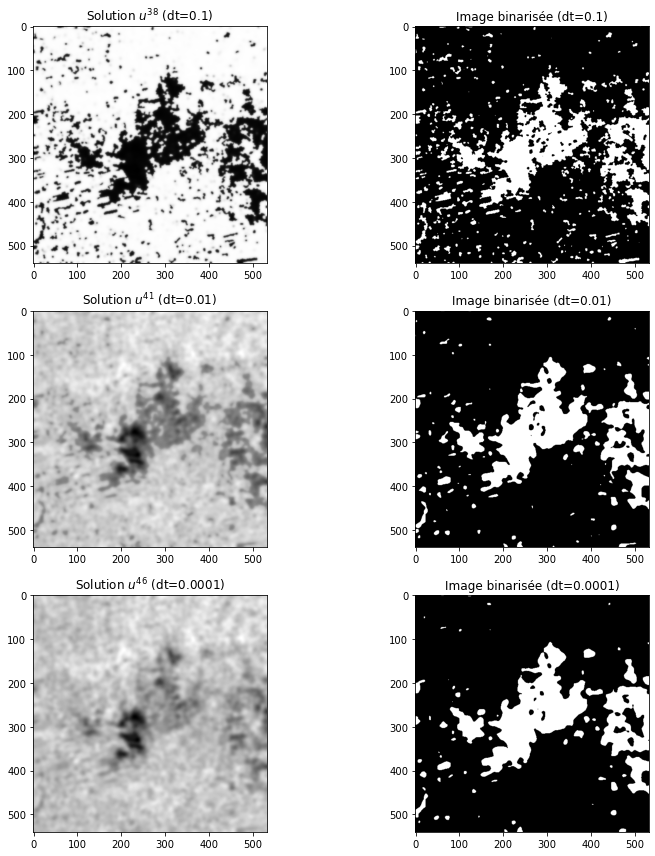

In [62]:
# Charger l'image SAR en niveaux de gris
u0 = np.loadtxt("sar.dat",delimiter=',')
m, n = u0.shape

# Tester la fonction segmente() avec différents pas de temps
dt_values = [0.1, 0.01, 0.0001]
kmax = 10000
eta = 0.001

plt.figure(figsize=(12,12))
for i, dt in enumerate(dt_values):
    u, S, k = segmente(u0, dt, kmax, eta)
    
    plt.subplot(3, 2, 2*i+1)
    plt.imshow(u, cmap='gray')
    plt.title(f'Solution $u^{({k})}$ (dt={dt})')
    
    plt.subplot(3, 2, 2*i+2)
    plt.imshow(S, cmap='gray')
    plt.title(f'Image binarisée (dt={dt})')

plt.tight_layout()
plt.show()

On observe que les images binarisées s'affinent de plus en plus. Autrement dit, les $(u_{i,j}^{(k)})$ convergent vers la solution.

#### Question 6
On appelle masque de neige l'ensemble des pixels identifiés comme neige
dans une image satellite.
Dans cette question, nous allons comparer
le masque de neige SAR obtenu par l'algorithme de réaction-diffusion et deux autres masques
dérivés de mesures optiques : ceux des satellites Sentinel-2 et SPOT-6
(dans les images binaires correspondantes, les pixels des zones de neige prennent la valeur $1$ et apparaissent en blanc).
<br><br>
Noter que le SAR est principalement sensible à la neige humide, tandis que l'optique
détecte la neige totale (neige humide et neige sèche située à plus haute altitude dans notre exemple), et que les dates des images
diffèrent légèrement : 
les images optiques SPOT-6 et Sentinel-2 correspondent au $25$ Avril 2018,
et l'image SAR de Sentinel-1 combine deux mesures des $27$ et $28$ Avril 2018.

#### 6-a)
On utilise la fonction **segmente** avec les paramètres
$\Delta{t}=0.07$, $k_{\mathrm{max}}=1000$, $\eta = 10^{-5}$.
L'image binaire $(S(u_{i,j}^{(k)}))$ obtenue constitue le masque de neige SAR.
Comparer (qualitativement et quantitativement)
cette image et les masques de neige optiques
des satellites SPOT-6 
(fichier de données **spot.dat**) et Sentinel-2 (**sentinel2.dat**).

#### Réponse :
<br>

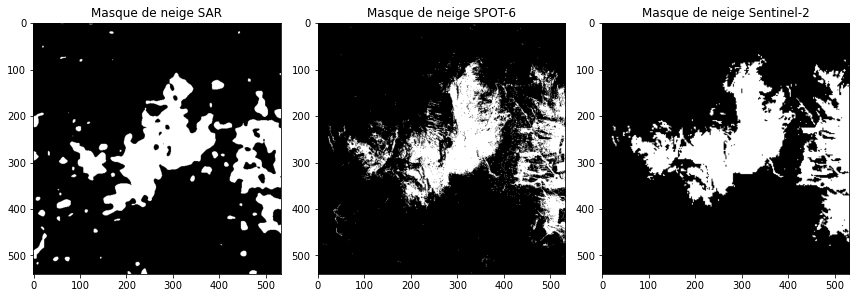

Indice de Jaccard entre les 3 masques: 0.41
Pourcentage de pixels détectés comme neige :
- Masque SAR: 17.87%
- Masque SPOT-6: 16.19%
- Masque Sentinel-2: 21.05%


In [63]:
u0 = np.loadtxt("sar.dat",delimiter=',')
u1 = np.loadtxt("sentinel2.dat",delimiter=',')
u2 = np.loadtxt("spot.dat",delimiter=',')

dt=0.07
kmax=1000
eta=10**(-5)
    # Comparaison qualitative

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(S, cmap='gray')
plt.title('Masque de neige SAR')
plt.subplot(1, 3, 2)
plt.imshow(u2, cmap='gray')
plt.title('Masque de neige SPOT-6')
plt.subplot(1, 3, 3)
plt.imshow(u1, cmap='gray')
plt.title('Masque de neige Sentinel-2'
         )
plt.tight_layout()
plt.show()

    # Comparaison quantitative
# Calcul de l'intersection et de l'union des masques
intersection = np.logical_and(S, np.logical_and(u2, u1))
union = np.logical_or(S, np.logical_or(u2, u1))
intersection_pixels = np.sum(intersection)
union_pixels = np.sum(union)

jaccard_index = intersection_pixels / union_pixels
print(f'Indice de Jaccard entre les 3 masques: {jaccard_index:.2f}')

sar_pixels = np.sum(S)
spot_pixels = np.sum(u2)
sentinel2_pixels = np.sum(u1)

sar_area = sar_pixels / (S.shape[0] * S.shape[1]) * 100
spot_area = spot_pixels / (u2.shape[0] * u2.shape[1]) * 100
sentinel2_area = sentinel2_pixels / (u1.shape[0] * u1.shape[1]) * 100

print(f'Pourcentage de pixels détectés comme neige :')
print(f'- Masque SAR: {sar_area:.2f}%')
print(f'- Masque SPOT-6: {spot_area:.2f}%')
print(f'- Masque Sentinel-2: {sentinel2_area:.2f}%')



On peut comparer quantitavivement les similarités des images en utilisant l'indice de Jaccard qui nous retourne la proportion de pixels similaires. Qualitativement, on voit que les zones de neige sont similaires et, en cela, notre traitement est satisfaisant. Cependant, le niveau de détails reste inférieure.

#### 6-b)
Pour comparer plus précisément les masques de neige SAR et optiques, 
on s'intéresse aux variations de la couverture neigeuse en fonction de l'altitude.
Les altitudes (exprimées en mètres)
aux différents pixels de l'image sont stockées dans le 
fichier de données **altitudes.dat**.
Tracer une carte couleur des altitudes
incluant quelques courbes de niveau.

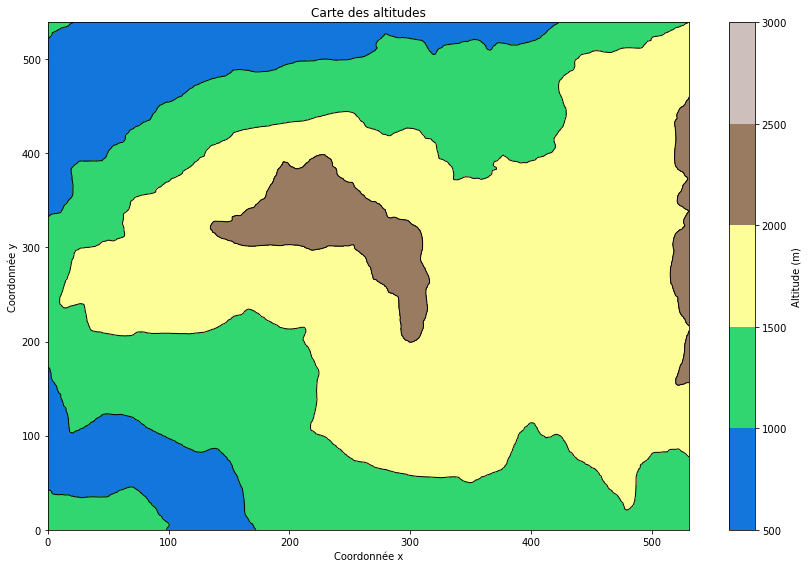

In [78]:
altitude = np.loadtxt("altitudes.dat",delimiter=',')
# Définition des niveaux de contour
levels = [500, 1000, 1500, 2000, 2500, 3000]

# Tracé de la carte couleur des altitudes avec les courbes de niveau
plt.figure(figsize=(12, 8))
plt.contourf(altitude, levels=levels, cmap='terrain')
plt.colorbar(label='Altitude (m)')
plt.contour(altitude, levels=levels, colors='k', linewidths=1)
plt.title('Carte des altitudes')
plt.xlabel('Coordonnée x')
plt.ylabel('Coordonnée y')
plt.tight_layout()
plt.show()

#### 6-c)
Ecrire une fonction **probaneige** qui
prend en arguments une altitude $h$ et un masque de neige 
$S=(s_{i,j})_{0\leq i \leq m-1 , 0\leq j \leq n-1}$ ($s_{i,j} \in \{0,1\}$),
et calcule la proportion $P_{S}(h)$ de pixels neige ($s_{i,j} =1$)
parmi les pixels dont les altitudes se situent 
dans l'intervalle $[h-75 , h+75]$.
Tracer (pour les altitudes $800m-2200m$)
les graphes des fonctions $P_{S}(h)$ pour les masques de neige
$S$ de SPOT, Sentinel-2 et du SAR, et commenter les résultats. 

#### Réponse :
<br>

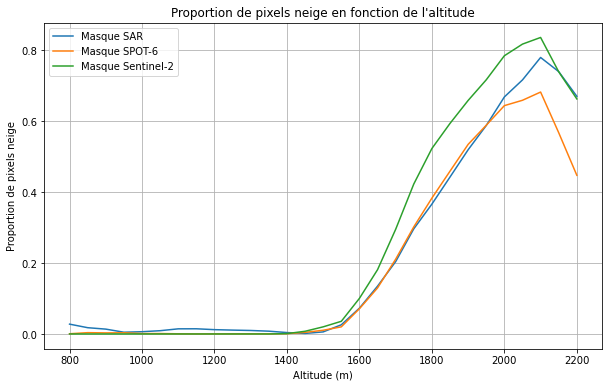

In [109]:
dt=0.07
kmax=1000
eta=10**(-5)

def probaneige(h, S , altitudes):
    m, n = S.shape
    s=0
    total=0
    for i in range(m):
        for j in range(n):
           if h-75 <= altitudes[i][j] <= h+75:
                total+=1
                if S[i][j] == 1:
                    s+=1

    return s/total

# Charger les données
altitudes = np.loadtxt("altitudes.dat",delimiter=',')
spot_mask = np.loadtxt("spot.dat",delimiter=',')
sentinel2_mask = np.loadtxt("sentinel2.dat",delimiter=',')
u0 = np.loadtxt("sar.dat",delimiter=',')
sar_mask = segmente(u0, dt, kmax, eta)[1]

# Tracé des graphes PS(h)
h_values = np.arange(800, 2201, 50)
plt.figure(figsize=(10, 6))

plt.plot(h_values, [probaneige(h, sar_mask,altitudes) for h in h_values], label='Masque SAR')
plt.plot(h_values, [probaneige(h, spot_mask,altitudes) for h in h_values], label='Masque SPOT-6')
plt.plot(h_values, [probaneige(h, sentinel2_mask,altitudes) for h in h_values], label='Masque Sentinel-2')

plt.xlabel('Altitude (m)')
plt.ylabel('Proportion de pixels neige')
plt.title('Proportion de pixels neige en fonction de l\'altitude')
plt.legend()
plt.grid()
plt.show()


On observe des proportions de neige par altitude proches mais tout de même différentes en fonction de la technique d'imagerie / du satellite utilisé.On remarquera que les valeurs sont cohérente avec ce que l'on peut observer sur le terrain.


#### 6-d)
En utilisant une fonction **scipy** de votre choix, calculer
pour les masques $S$ de neige SPOT, Sentinel-2 et SAR
l'altitude moyenne d'apparition de la neige $\bar{h}_{S}$ définie par :
$$
P_{S}(\bar{h}_{S})=1/2, \quad P_{S}(h)<1/2 \ \mbox{pour tout}\ h< \bar{h}_{S}.
$$
Commenter les résultats obtenus.

#### Réponse :
<br>

In [113]:
from scipy.stats import percentileofscore, scoreatpercentile

def snow_altitude(h_values, ps_values):
    # Interpolation de la fonction PS(h)
    ps_interp = interp1d(h_values, [ps-0.5 for ps in ps_values])
    # Recherche de l'altitude h_S telle que PS(h_S) = 0.5
    h_s = newton(ps_interp, 1500)
    return h_s


dt=0.07
kmax=1000
eta=10**(-5)

# Charger les données
altitudes = np.loadtxt("altitudes.dat",delimiter=',')
u0 = np.loadtxt("sar.dat",delimiter=',')
sar_mask = segmente(u0, dt, kmax, eta)[1]
spot_mask = np.loadtxt("spot.dat",delimiter=',')
sentinel2_mask = np.loadtxt("sentinel2.dat",delimiter=',')

# Calculer l'altitude moyenne d'apparition de la neige pour chaque masque
h_values = np.arange(1200, 2200, 50)

def altitude_limite_neige(limite,h_values, mask, altitudes):
    proba = [probaneige(h, mask, altitudes) for h in h_values]
    index = int(len(h_values)*percentileofscore(proba, 0.5,kind="strict")/100)+1
    return h_values[index]


limite = 0.5
sar_ps = altitude_limite_neige(limite, h_values, sar_mask, altitudes)
spot_ps = altitude_limite_neige(limite, h_values
                                , spot_mask, altitudes)
sentinel2_ps = altitude_limite_neige(limite, h_values, sentinel2_mask, altitudes)


print(f"Altitude moyenne d'apparition de la neige :")
print(f"- Masque SAR : {sar_ps:.0f} m")
print(f"- Masque SPOT-6 : {spot_ps:.0f} m")
print(f"- Masque Sentinel-2 : {sentinel2_ps:.0f} m")


Altitude moyenne d'apparition de la neige :
- Masque SAR : 1950 m
- Masque SPOT-6 : 1950 m
- Masque Sentinel-2 : 1850 m


Les résultats sont similaires et cohérents. On peut donc se fier à ces résultats.